# Recommendation System

A recommendation system is an artificial intelligence algorithm designed to suggest relevant items to users based on their preferences, behavior, or similarities to other users. These systems are widely used in various applications, including e-commerce platforms, streaming services, social media, and content websites.

Key features of recommendation systems include:

1. Personalization: Tailoring suggestions to individual user preferences.
2. Improved user experience: Helping users discover new content or products they might enjoy.
3. Increased engagement: Encouraging users to interact more with the platform.
4. Business value: Driving sales, subscriptions, or other desired user actions.

Recommendation systems typically employ various techniques and algorithms to generate accurate and relevant suggestions, which we will explore in more detail in the following sections.


# Types of recommendation engine

 1. Content based (no user past experience is needed)
 2. Collaborative Filter based(based on user's past behavior)
 3. Ontology Based - Need verification

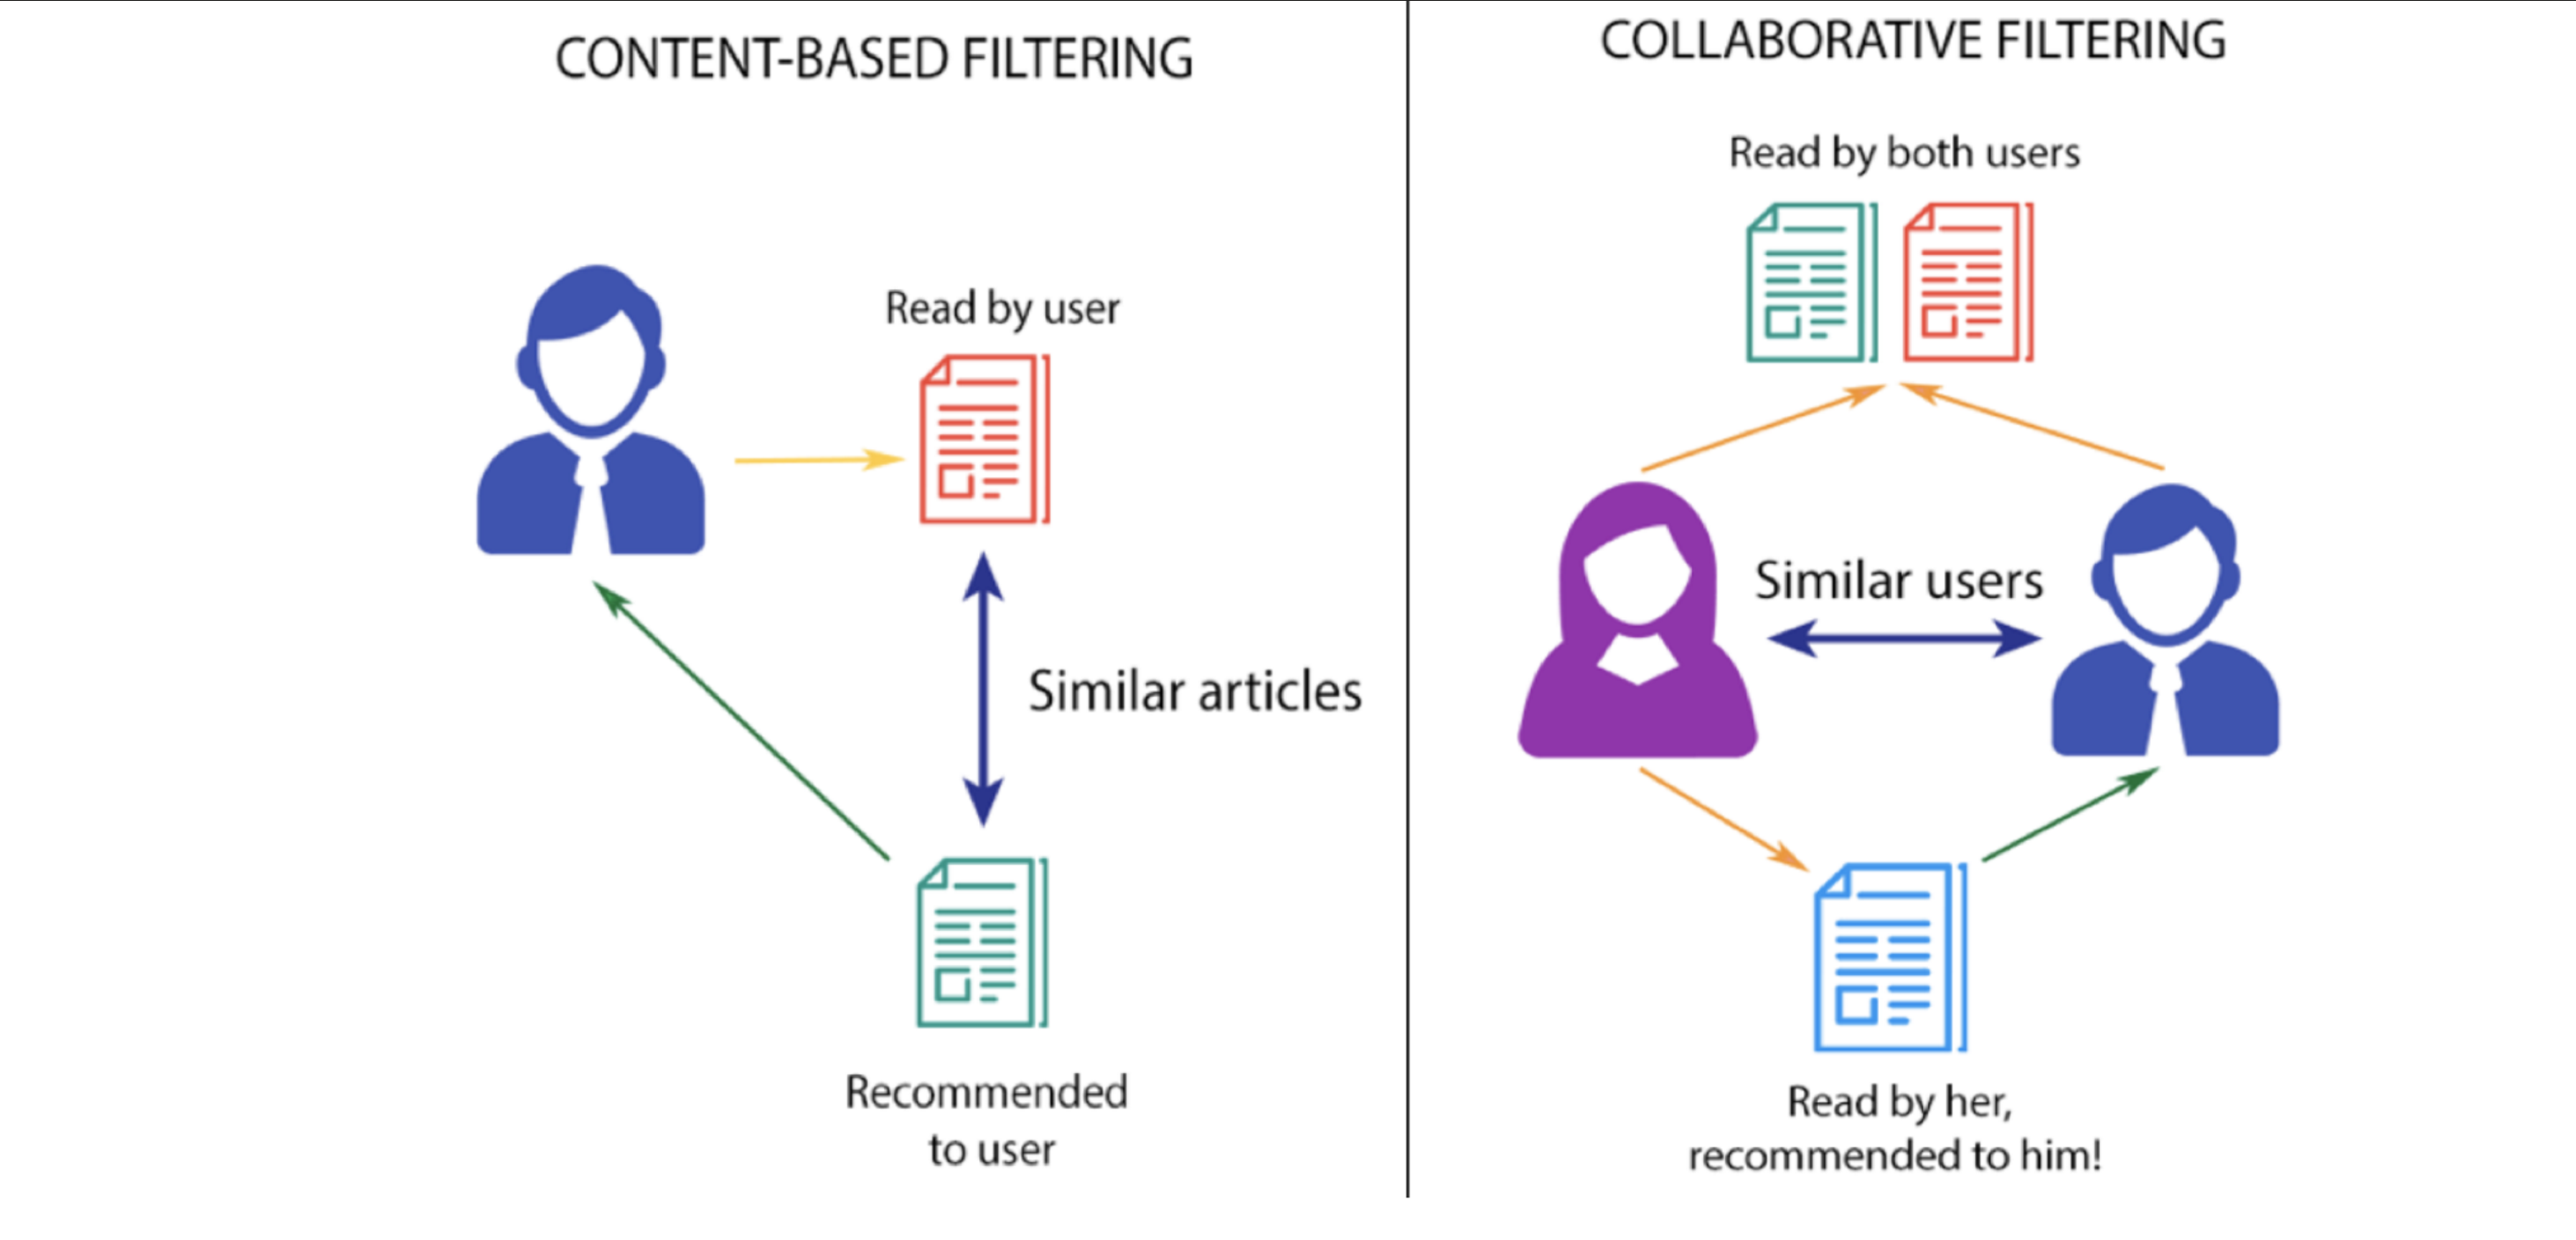

## content based recommendation

The algorithm recommends products that are similar to the ones that a user has liked in the past. 

This similarity (generally cosine similarity) is computed from the data we have about the items as well as the user’s past preferences.

For example, 

if a user likes movies such as ‘The Prestige’ then we can recommend him the movies of ‘Christian Bale’ or movies with the genre ‘Thriller’ or maybe even movies directed by ‘Christopher Nolan’.So what happens here the recommendation system checks the past preferences of the user and find the film “The Prestige”, then tries to find similar movies to that using the information available in the database such as the lead actors, the director, genre of the film, production house, etc and based on this information find movies similar to “The Prestige”.


Advantages:

1. Personalization: Recommendations are tailored to individual user preferences.
2. No item cold start problem: New items can be recommended based on their features.
3. Transparency: Easy to explain why a particular item was recommended.
4. No need for other users' data: Can work with just one user's preferences.
5. Good handling of new items: Can recommend newly added items immediately.
6. Flexibility across domains: Can be applied to various types of content.

Disadvantages

1. Different products(non similar items) do not get much exposure to the user.
2. Businesses cannot be expanded as the user does not try different types of products.

In [1]:
# example for content based filtering using python
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sample movie data
movies = pd.DataFrame({
    'title': ['The Prestige', 'Inception', 'The Dark Knight', 'Interstellar', 'Memento'],
    'director': ['Christopher Nolan', 'Christopher Nolan', 'Christopher Nolan', 'Christopher Nolan', 'Christopher Nolan'],
    'genre': ['Thriller', 'Sci-Fi', 'Action', 'Sci-Fi', 'Thriller'],
    'lead_actor': ['Christian Bale', 'Leonardo DiCaprio', 'Christian Bale', 'Matthew McConaughey', 'Guy Pearce']
})

# Combine relevant features into a single string
movies['features'] = movies['director'] + ' ' + movies['genre'] + ' ' + movies['lead_actor']

# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(movies['features'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movies[movies['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # Top 5 similar movies
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

# Example usage
print(get_recommendations('The Prestige'))


2    The Dark Knight
4            Memento
1          Inception
3       Interstellar
Name: title, dtype: object


# Collaborative Filtering Recommendation System

Collaborative filtering is a technique used in recommendation systems that makes predictions about a user's interests by collecting preferences from many users. It operates on the assumption that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person.

There are two main types of collaborative filtering:

1. User-Based Collaborative Filtering: This approach identifies users with similar preferences to the target user and recommends items that these similar users have liked.

2. Item-Based Collaborative Filtering: This method finds items similar to those the target user has liked in the past and recommends them.

Both approaches typically use techniques like cosine similarity or Pearson correlation to measure similarity between users or items.

In the next cell, we'll implement a simple user-based collaborative filtering system using Python and the Surprise library, which is specifically designed for building and analyzing recommender systems.


## example for User-Based Collaborative Filtering

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Sample user-movie ratings data
ratings_data = {
    'user_id': [1, 1, 1, 2, 2, 3, 3, 3, 4, 4],
    'movie_id': [1, 2, 3, 1, 2, 2, 3, 4, 1, 4],
    'rating': [5, 4, 3, 3, 2, 4, 5, 5, 1, 2]
}

# Create a DataFrame
df = pd.DataFrame(ratings_data)

# Create a user-item matrix
user_item_matrix = df.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)

# Calculate cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)

# Function to get top N similar users
def get_similar_users(user_id, N=3):
    user_idx = user_item_matrix.index.get_loc(user_id)
    similar_users = user_similarity[user_idx].argsort()[::-1][1:N+1]
    return user_item_matrix.index[similar_users]

# Function to get recommendations for a user
def get_user_recommendations(user_id, N=5):
    similar_users = get_similar_users(user_id)
    user_ratings = user_item_matrix.loc[user_id]
    similar_users_ratings = user_item_matrix.loc[similar_users]
    
    # Calculate weighted ratings
    weighted_ratings = similar_users_ratings.mul(user_similarity[user_item_matrix.index.get_loc(user_id)][user_item_matrix.index.get_indexer(similar_users)].reshape(-1, 1), axis=0)
    
    # Sum up the weighted ratings and normalize
    recommendation_scores = weighted_ratings.sum(axis=0) / user_similarity[user_item_matrix.index.get_loc(user_id)][user_item_matrix.index.get_indexer(similar_users)].sum()
    
    # Remove movies the user has already rated
    recommendation_scores = recommendation_scores[user_ratings == 0]
    
    # Sort and get top N recommendations
    top_recommendations = recommendation_scores.sort_values(ascending=False).head(N)
    
    return top_recommendations

# Example usage
user_id = 1
recommendations = get_user_recommendations(user_id)
print(f"Top 5 movie recommendations for user {user_id}:")
print(recommendations)


Top 5 movie recommendations for user 1:
movie_id
4    1.89457
dtype: float64


## Item-Based Collaborative Filtering


Note: item_item_matrix is the base for all approaches below.

### using cosine similarity

In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# Assuming we have the same 'df' DataFrame as in the user-based approach

# Create an item-item matrix
item_item_matrix = df.pivot(index='movie_id', columns='user_id', values='rating').fillna(0)

# Calculate cosine similarity between items
item_similarity = cosine_similarity(item_item_matrix)

# Function to get top N similar items
def get_similar_items(movie_id, N=5):
    movie_idx = item_item_matrix.index.get_loc(movie_id)
    similar_items = item_similarity[movie_idx].argsort()[::-1][1:N+1]
    return item_item_matrix.index[similar_items]

# Function to get recommendations for a user based on item similarity
def get_item_based_recommendations(user_id, N=5):
    user_ratings = df[df['user_id'] == user_id]
    
    # Get similar items for each item the user has rated
    similar_items = {}
    for _, row in user_ratings.iterrows():
        movie_id = row['movie_id']
        similar_items[movie_id] = get_similar_items(movie_id)
    
    # Calculate recommendation scores
    recommendation_scores = {}
    for movie_id, similar_movies in similar_items.items():
        user_rating = user_ratings[user_ratings['movie_id'] == movie_id]['rating'].values[0]
        for similar_movie in similar_movies:
            if similar_movie not in user_ratings['movie_id'].values:
                similarity = item_similarity[item_item_matrix.index.get_loc(movie_id)][item_item_matrix.index.get_loc(similar_movie)]
                recommendation_scores[similar_movie] = recommendation_scores.get(similar_movie, 0) + (user_rating * similarity)
    
    # Sort and get top N recommendations
    top_recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)[:N]
    
    return pd.Series({movie_id: score for movie_id, score in top_recommendations})

# Example usage
user_id = 1
item_based_recommendations = get_item_based_recommendations(user_id)
print(f"Top 5 movie recommendations for user {user_id} (Item-Based):")
print(item_based_recommendations)


Top 5 movie recommendations for user 1 (Item-Based):
4    5.178307
dtype: float64


### using KNN

In [5]:
from sklearn.neighbors import NearestNeighbors

# Function to get KNN-based recommendations for a user
def get_knn_based_recommendations(user_id, N=5, K=3):
    # Create a user-item matrix
    user_item_matrix = df.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    
    # Initialize and fit the KNN model
    knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=K, n_jobs=-1)
    knn_model.fit(user_item_matrix)
    
    # Get the K nearest neighbors
    user_index = user_item_matrix.index.get_loc(user_id)
    distances, indices = knn_model.kneighbors(user_item_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=K+1)
    
    # Get the movies rated by the user
    user_rated_movies = set(df[df['user_id'] == user_id]['movie_id'])
    
    # Calculate recommendation scores
    recommendation_scores = {}
    for i in range(1, len(indices.flatten())):
        neighbor_id = user_item_matrix.index[indices.flatten()[i]]
        neighbor_ratings = df[df['user_id'] == neighbor_id]
        
        for _, row in neighbor_ratings.iterrows():
            movie_id = row['movie_id']
            if movie_id not in user_rated_movies:
                similarity = 1 - distances.flatten()[i]  # Convert distance to similarity
                recommendation_scores[movie_id] = recommendation_scores.get(movie_id, 0) + (row['rating'] * similarity)
    
    # Sort and get top N recommendations
    top_recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)[:N]
    
    return pd.Series({movie_id: score for movie_id, score in top_recommendations})

# Example usage
user_id = 1
knn_based_recommendations = get_knn_based_recommendations(user_id)
print(f"Top 5 movie recommendations for user {user_id} (KNN-Based):")
print(knn_based_recommendations)


Top 5 movie recommendations for user 1 (KNN-Based):
4    3.330659
dtype: float64


### using pandas

In [6]:
# Function to get correlation-based recommendations for a user
def get_correlation_based_recommendations(user_id, N=5):
    # Create a user-item matrix
    user_item_matrix = df.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    
    # Get the user's ratings
    user_ratings = user_item_matrix.loc[user_id]
    
    # Calculate the correlation between the user's ratings and all other users' ratings
    correlations = user_item_matrix.corrwith(user_ratings)
    
    # Remove NaN values and sort correlations in descending order
    correlations = correlations.dropna().sort_values(ascending=False)
    
    # Get the top correlated users (excluding the user themselves)
    top_correlated_users = correlations[correlations.index != user_id][:10]
    
    # Get movies rated by the user
    user_rated_movies = set(df[df['user_id'] == user_id]['movie_id'])
    
    # Calculate recommendation scores
    recommendation_scores = {}
    for corr_user, correlation in top_correlated_users.items():
        corr_user_ratings = df[df['user_id'] == corr_user]
        for _, row in corr_user_ratings.iterrows():
            movie_id = row['movie_id']
            if movie_id not in user_rated_movies:
                recommendation_scores[movie_id] = recommendation_scores.get(movie_id, 0) + (row['rating'] * correlation)
    
    # Sort and get top N recommendations
    top_recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)[:N]
    
    return pd.Series({movie_id: score for movie_id, score in top_recommendations})

# Example usage
user_id = 1
correlation_based_recommendations = get_correlation_based_recommendations(user_id)
print(f"\nTop 5 movie recommendations for user {user_id} (Correlation-Based):")
print(correlation_based_recommendations)



Top 5 movie recommendations for user 1 (Correlation-Based):
4    1.106195
dtype: float64
